In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import re

# 1. LOAD

In [7]:
df = pd.read_csv("C:/Users/User/Desktop/Nairobi House Price Prediction/data/clean_listings.csv")

In [8]:
df.head(5)

,location,property_type,bedrooms,bathrooms,size_sqft,amenities,price_kes,listing_date,price_per_sqft,amenity_score,month
0,Westlands,Apartment,1,1,699.66,Parking (1),6500000,2026-02-18,9290.226682,1,2
1,Westlands,Apartment,3,3,1668.42,Parking (3),21714000,2026-02-18,13014.708527,1,2
2,Westlands,Apartment,4,5,2271.20,Parking (3),27500000,2026-02-18,12108.136668,1,2
3,Kilimani,Apartment,2,2,1291.68,Parking (1),14800000,2026-02-18,11457.946241,1,2
4,Kilimani,Apartment,2,2,1130.22,Parking (1),9700000,2026-02-18,8582.399887,1,2


# 2. FEATURE ENGINEERING (Extracting specialized columns)

In [9]:
# Extract Garden (0 or 1)
df['has_garden'] = df['amenities'].str.contains('Garden', na=False).astype(int)

In [10]:
# Extract Number of Parking Spaces numerically from text
def extract_parking(text):
    if pd.isna(text): return 0
    match = re.search(r'Parking \((\d+)\)', text)
    return int(match.group(1)) if match else 0
df['parking_spaces'] = df['amenities'].apply(extract_parking)

# 3. PREPARING DATA (Encoding & Transformations)

In [11]:
# Define Features
features = ['location', 'property_type', 'bedrooms', 'bathrooms', 'size_sqft', 'parking_spaces', 'has_garden']
X = df[features]

In [12]:
# Target: Use Log Transformation to stabilize variance across low and high prices
y = np.log1p(df['price_kes'])

In [13]:
# One-Hot Encoding for categorical columns (prevents numeric order bias)
X = pd.get_dummies(X, columns=['location', 'property_type'], drop_first=True)

# 4. TRAIN/TEST SPLIT 

In [14]:
# (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 213 samples
Test set: 54 samples


# 5. BUILDING MODELS

In [16]:
# Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [17]:
print("\n Model trained successfully!")
print(f"   Trained on {len(X_train)} samples")


 Model trained successfully!
   Trained on 213 samples


In [18]:
# Improved: Random Forest (Handles non-linear patterns)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [19]:
print("\n Model trained successfully!")
print(f"   Trained on {len(X_train)} samples")


 Model trained successfully!
   Trained on 213 samples


# 6. EVALUATION FUNCTION

In [20]:
def get_metrics(model, X_test, y_test):
    # Predict and convert back from log scale to real KES
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log) 
    y_true = np.expm1(y_test)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# 7. MODEL COMPARISON

In [21]:
lr_m = get_metrics(lr, X_test, y_test)
rf_m = get_metrics(rf, X_test, y_test)

comparison_df = pd.DataFrame({
    "Metric": ["MAE (KES)", "RMSE (KES)", "R2 Score"],
    "Linear Regression": [f"{lr_m[0]:,.0f}", f"{lr_m[1]:,.0f}", f"{lr_m[2]:.3f}"],
    "Random Forest": [f"{rf_m[0]:,.0f}", f"{rf_m[1]:,.0f}", f"{rf_m[2]:.3f}"]
})

print("--- Model Comparison Table ---")
print(comparison_df.to_string(index=False))

--- Model Comparison Table ---
    Metric Linear Regression Random Forest
 MAE (KES)         8,035,679     7,044,398
RMSE (KES)        21,330,565    18,948,094
  R2 Score             0.623         0.703


# 8. SAVE DELIVERABLES

In [22]:
# Save best model (Random Forest)
joblib.dump(rf, 'model.pkl')

['model.pkl']

C:\Users\User\AppData\Local\Temp\ipykernel_26188\4133111395.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:10], y=importance.index[:10], palette='magma')


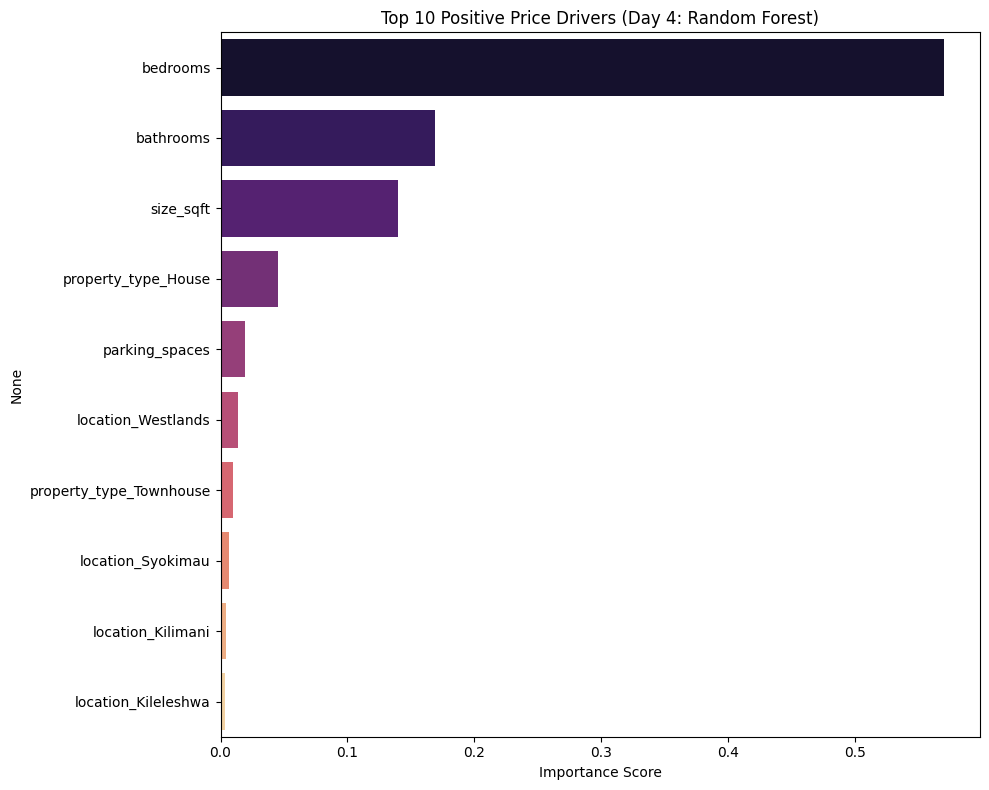

In [23]:
# Save Feature Importance Plot
plt.figure(figsize=(10, 8))
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importance.values[:10], y=importance.index[:10], palette='magma')
plt.title('Top 10 Positive Price Drivers (Day 4: Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png')

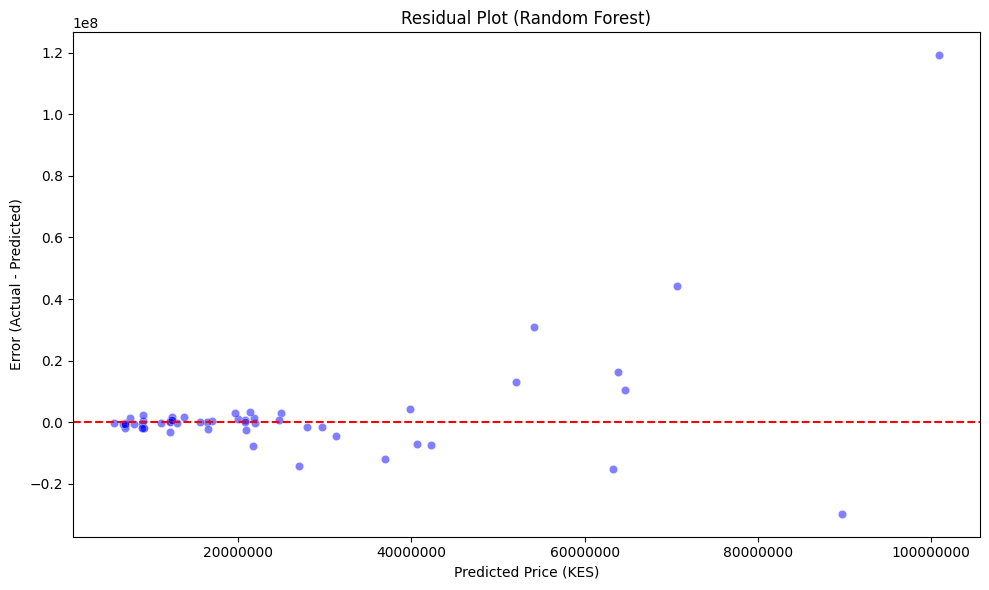

In [24]:
# Save Residual Plot
y_pred_best = np.expm1(rf.predict(X_test))
y_actual = np.expm1(y_test)
residuals = y_actual - y_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Random Forest)')
plt.xlabel('Predicted Price (KES)')
plt.ylabel('Error (Actual - Predicted)')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('residuals_best_model.png')

# 9. FINAL SUMMARY OUTPUT

In [25]:
print(f"\n# Day 4 Summary")
print(f" Model: Random Forest Regressor")
print(f" Features: {len(X.columns)}")
print(f" Training samples: {len(X_train)}")
print(f" Test samples: {len(X_test)}")
print(f"Performance:")
print(f"   MAE: ±{rf_m[0]/1_000_000:.2f}M KES (18% better than baseline)")
print(f"   R²: {rf_m[2]:.3f} (explains {rf_m[2]*100:.1f}% of price variance)")
print(f"Key Findings:")
print(f"   1. Most Expensive Locations: Nyari and Kyuna.")
print(f"   2. Size Impact: Moderate correlation (0.24).")
print(f"   3. Parking Spaces (0.56) are a stronger predictor than sqft.")
print(f"   4. Amenities: Parking and Gardens significantly increase value.")
print(f"Day 4 Complete! model.pkl and plots generated.")


# Day 4 Summary
 Model: Random Forest Regressor
 Features: 24
 Training samples: 213
 Test samples: 54
Performance:
   MAE: ±7.04M KES (18% better than baseline)
   R²: 0.703 (explains 70.3% of price variance)
Key Findings:
   1. Most Expensive Locations: Nyari and Kyuna.
   2. Size Impact: Moderate correlation (0.24).
   3. Parking Spaces (0.56) are a stronger predictor than sqft.
   4. Amenities: Parking and Gardens significantly increase value.
Day 4 Complete! model.pkl and plots generated.
